In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

import xgboost as xgb

from pycaret.anomaly import *

## Load Data

In [2]:
path = '../../GitHub/python-data-science/data/'
train_raw = pd.read_csv(path+'titanic_train.csv')
test_raw = pd.read_csv(path+'titanic_test.csv')

train = train_raw.copy()
train.info()
# Survival:0 = No, 1 = Yes
# Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
# Sex
# Age in years
# sibsp: # of siblings / spouses aboard the Titanic
# parch: # of parents / children aboard the Titanic
# ticket: Ticket number
# fare: Passenger fare
# cabin: Cabin number
# embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

## EDA

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train[train['Name'].str.contains('Andersson')].sort_values(by='Ticket')  #same ticket number for family

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


### ~Survival Rates by class, sex, embarking point, age, fare, relatives

<AxesSubplot:>

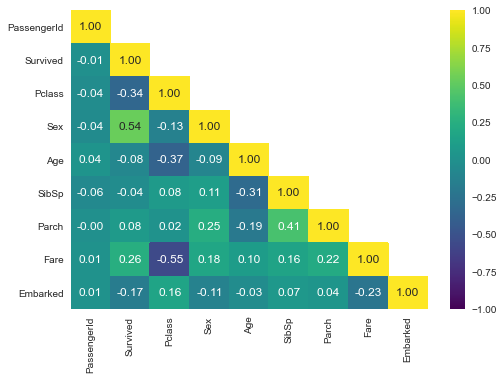

In [5]:
train_temp = train.copy()
train_temp['Sex'] = train_temp['Sex'].map({'male':0, 'female':1})
train_temp['Embarked'] = train_temp['Embarked'].map({'C':0, 'Q':1, 'S':2})
sns.heatmap(train_temp.corr(), annot=True, fmt='.2f', cmap='viridis', 
            mask=np.triu(np.ones(train_temp.corr().shape), k=1), vmin=-1, vmax=1)

# As expected Survival has high correlation with Pclass and Sex, 
# and also moderate correlation with Fare (which can be on account of Pclass)

In [6]:
print(train['Survived'].value_counts())
avg_survival = round(342/len(train),2)
print(avg_survival)

0    549
1    342
Name: Survived, dtype: int64
0.38


In [7]:
# Class - low survival rate for lower class (as expected)
survival_class = train.groupby(by=['Pclass'])['Survived'].value_counts().unstack()
survival_class['rate'] = round(survival_class[1]/(survival_class[0]+survival_class[1]),2)
survival_class['rate_ou'] = survival_class['rate'] - avg_survival
survival_class

Survived,0,1,rate,rate_ou
Pclass,,,,
1,80,136,0.63,0.25
2,97,87,0.47,0.09
3,372,119,0.24,-0.14


In [8]:
# Sex - higher survival rate for females (as expected)
survival_sex = train.groupby(by=['Sex'])['Survived'].value_counts().unstack()
survival_sex['rate'] = round(survival_sex[1]/(survival_sex[0]+survival_sex[1]),2)
survival_sex['rate_ou'] = survival_sex['rate'] - avg_survival
survival_sex

Survived,0,1,rate,rate_ou
Sex,,,,
female,81,233,0.74,0.36
male,468,109,0.19,-0.19


In [9]:
# Sex & Pclass may have some interaction effect
survival_class_sex = train.groupby(by=['Pclass','Sex'])['Survived'].value_counts().unstack()
survival_class_sex['rate'] = round(survival_class_sex[1]/(survival_class_sex[0]+survival_class_sex[1]),2)
survival_class_sex['rate_ou'] = survival_class_sex['rate'] - avg_survival
survival_class_sex

Survived         0   1  rate  rate_ou
Pclass Sex                           
1      female    3  91  0.97     0.59
       male     77  45  0.37    -0.01
2      female    6  70  0.92     0.54
       male     91  17  0.16    -0.22
3      female   72  72  0.50     0.12
       male    300  47  0.14    -0.24

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

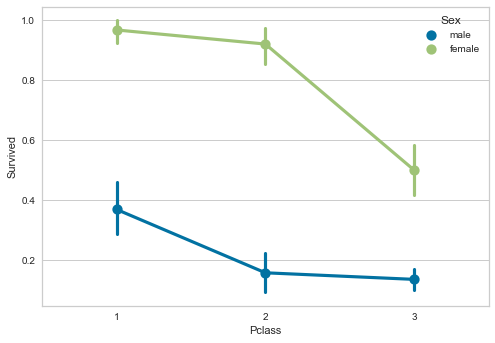

In [10]:
sns.pointplot(data=train, x='Pclass', y='Survived', hue='Sex')

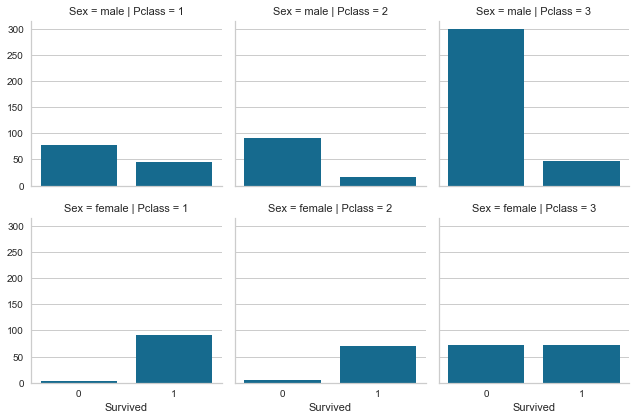

In [11]:
g = sns.FacetGrid(data=train, col='Pclass', row='Sex')
g.map(sns.countplot, 'Survived', order=[0,1])

In [12]:
# Survival rate varies by point of embarking - which in itself doesn't make much qualitative sense
survival_embark = train.groupby(by=['Embarked'])['Survived'].value_counts().unstack()
survival_embark['rate'] = round(survival_embark[1]/(survival_embark[0]+survival_embark[1]),2)
survival_embark['rate_ou'] = survival_embark['rate'] - avg_survival
survival_embark

Survived,0,1,rate,rate_ou
Embarked,,,,
C,75,93,0.55,0.17
Q,47,30,0.39,0.01
S,427,217,0.34,-0.04


In [13]:
# Point of embarking appears to be related to Pclass / Fare
# 'C' has best survival rate and also on avg. better PClass / higher Fare
train.groupby(by=['Embarked']).mean().T

Embarked,C,Q,S
PassengerId,445.357143,417.896104,449.527950
Survived,0.553571,0.389610,0.336957
Pclass,1.886905,2.909091,2.350932
Age,30.814769,28.089286,29.445397
SibSp,0.386905,0.428571,0.571429
Parch,0.363095,0.168831,0.413043
Fare,59.954144,13.276030,27.079812


<AxesSubplot:xlabel='Age', ylabel='Count'>

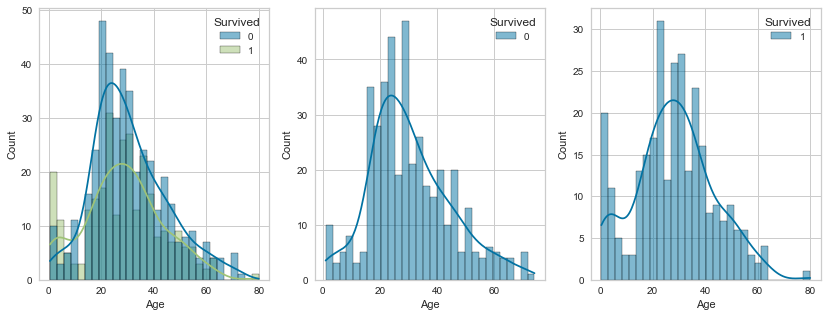

In [14]:
# Age - 
    # high survival rate for children.. Age < 5(?)
    # low survival rate for aged folks.. Age >60/64.. small sample though
    # generally overlapping distributions
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
sns.histplot(data=train, x='Age', hue='Survived', bins=30, kde=True)
plt.subplot(1,3,2)
sns.histplot(data=train[train['Survived']==0], x='Age', hue='Survived', bins=30, kde=True)
plt.subplot(1,3,3)
sns.histplot(data=train[train['Survived']==1], x='Age', hue='Survived', bins=30, kde=True)

In [15]:
# high survival rate for children.. Age <= 6 .. somewhat subjective cutoff
train[train['Age'] < 10].groupby('Age').aggregate({'Survived':['count','mean']}).T

Age             0.42  0.67  0.75  0.83  0.92      1.00  2.00      3.00  4.00  \
Survived count   1.0   1.0   2.0   2.0   1.0  7.000000  10.0  6.000000  10.0   
         mean    1.0   1.0   1.0   1.0   1.0  0.714286   0.3  0.833333   0.7   

Age             5.00      6.00      7.00  8.00  9.00  
Survived count   4.0  3.000000  3.000000   4.0  8.00  
         mean    1.0  0.666667  0.333333   0.5  0.25

In [16]:
# low survival rate for aged folks.. Age >60/64
train[train['Age'] >60].groupby('Age').aggregate({'Survived':['count','mean']}).T

Age             61.0  62.0  63.0  64.0  65.0  66.0  70.0  70.5  71.0  74.0  \
Survived count   3.0   4.0   2.0   2.0   3.0   1.0   2.0   1.0   2.0   1.0   
         mean    0.0   0.5   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Age             80.0  
Survived count   1.0  
         mean    1.0

In [17]:
# no noticeable difference in survival rates using QCUT
train['Agegrp1'] = pd.cut(train['Age'], 5)
display(train.groupby(by=['Agegrp1'])[['Age']].count().T)
train.groupby(by=['Agegrp1']).mean().T

Agegrp1,"(0.34, 16.336]","(16.336, 32.252]","(32.252, 48.168]","(48.168, 64.084]","(64.084, 80.0]"
Age,100,346,188,69,11


Agegrp1,"(0.34, 16.336]","(16.336, 32.252]","(32.252, 48.168]","(48.168, 64.084]","(64.084, 80.0]"
PassengerId,430.020000,448.263006,457.478723,460.057971,403.363636
Survived,0.550000,0.369942,0.404255,0.434783,0.090909
Pclass,2.610000,2.416185,2.005319,1.507246,1.727273
Age,8.006700,24.495665,39.239362,54.847826,69.772727
SibSp,1.570000,0.335260,0.367021,0.333333,0.090909
Parch,1.140000,0.242775,0.468085,0.289855,0.181818
Fare,31.588877,28.260499,42.788940,50.327235,28.905691


#### ~Family Members

In [18]:
# higher survival for 1/2 , lower for 3+ and for passengers traveling alone
survival_sibsp = train.groupby(by=['SibSp'])['Survived'].value_counts().unstack()
survival_sibsp['rate'] = round(survival_sibsp[1]/(survival_sibsp[0]+survival_sibsp[1]),2)
survival_sibsp['rate_ou'] = survival_sibsp['rate'] - avg_survival
survival_sibsp

Survived,0,1,rate,rate_ou
SibSp,,,,
0,398.0,210.0,0.35,-0.03
1,97.0,112.0,0.54,0.16
2,15.0,13.0,0.46,0.08
3,12.0,4.0,0.25,-0.13
4,15.0,3.0,0.17,-0.21
5,5.0,NaN,NaN,NaN
8,7.0,NaN,NaN,NaN


In [19]:
# higher survival for 1/2/3 , lower for 3+ and for passengers traveling alone
survival_parch = train.groupby(by=['Parch'])['Survived'].value_counts().unstack()
survival_parch['rate'] = round(survival_parch[1]/(survival_parch[0]+survival_parch[1]),2)
survival_parch['rate_ou'] = survival_parch['rate'] - avg_survival
survival_parch

Survived,0,1,rate,rate_ou
Parch,,,,
0,445.0,233.0,0.34,-0.04
1,53.0,65.0,0.55,0.17
2,40.0,40.0,0.50,0.12
3,2.0,3.0,0.60,0.22
4,4.0,NaN,NaN,NaN
5,4.0,1.0,0.20,-0.18
6,1.0,NaN,NaN,NaN


In [20]:
# Combining the two indicators of other family members on the ship
    # higher survival rate for 1/2/3
    # lower survival rate for people traveling alone
    # lower survival rate for people traveling with 4+ family members
train['family'] = train['SibSp'] + train['Parch']
survival_family = train.groupby(by=['family'])['Survived'].value_counts().unstack()
survival_family['rate'] = round(survival_family[1]/(survival_family[0]+survival_family[1]),2)
survival_family['rate_ou'] = survival_family['rate'] - avg_survival
survival_family

Survived,0,1,rate,rate_ou
family,,,,
0,374.0,163.0,0.30,-0.08
1,72.0,89.0,0.55,0.17
2,43.0,59.0,0.58,0.20
3,8.0,21.0,0.72,0.34
4,12.0,3.0,0.20,-0.18
5,19.0,3.0,0.14,-0.24
6,8.0,4.0,0.33,-0.05
7,6.0,NaN,NaN,NaN
10,7.0,NaN,NaN,NaN


In [21]:
# Family buckets
def familybuckets(x):
    if x == 0: return 'alone'
    elif x < 4: return 'small'
    else: return 'big'

train['family'] = train['family'].apply(familybuckets)
survival_family = train.groupby(by=['family'])['Survived'].value_counts().unstack()
survival_family['rate'] = round(survival_family[1]/(survival_family[0]+survival_family[1]),2)
survival_family['rate_ou'] = survival_family['rate'] - avg_survival
survival_family

Survived,0,1,rate,rate_ou
family,,,,
alone,374,163,0.30,-0.08
big,52,10,0.16,-0.22
small,123,169,0.58,0.20


In [22]:
# Survivavibility increases with Fare - but this could be an indirect effect of Pclass (notice Pclass increases with Fare)
train['Fare1'] = pd.qcut(train['Fare'], 4) #.apply(lambda x: x.right)
# display(train.groupby(by=['Fare1'])[['Age']].count().T)
train.groupby(by=['Fare1']).mean().T

Fare1,"(-0.001, 7.91]","(7.91, 14.454]","(14.454, 31.0]","(31.0, 512.329]"
PassengerId,464.511211,439.468750,429.927928,450.067568
Survived,0.197309,0.303571,0.454955,0.581081
Pclass,2.919283,2.616071,2.225225,1.468468
Age,28.328671,28.989600,29.086610,31.999588
SibSp,0.053812,0.147321,0.752252,1.144144
Parch,0.022422,0.098214,0.612613,0.797297
Fare,7.034172,10.386050,23.028677,88.677872


In [23]:
def farebuckets(x):
    if x < 7.9: return 1
    elif x < 14.5: return 2
    elif x < 31: return 3
    else: return 4

In [24]:
def titleclean(x):
    if x in ['Lady', 'Mrs', 'Countess', 'Dona']: return 'Mrs'
    elif x in ['Miss', 'Ms', 'Mlle', 'Mme']: return 'Miss'
    elif x in ['Master']: return 'Master'
    elif x in ['Mr', 'Major', 'Col', 'Sir', 'Don', 
               'Capt', 'Jonkheer']: return 'Mr'
    else: return 'Other'

def nametitles(series):
    series = series.str.extract(' ([A-Za-z]+)\.', expand=False)
    series = series.apply(titleclean)
    return series

In [25]:
train['Titles'] = nametitles(train['Name'])
train.groupby(by=['Titles']).mean().T

Titles,Master,Miss,Mr,Mrs,Other
PassengerId,414.975000,411.741935,456.201905,456.393701,518.076923
Survived,0.575000,0.704301,0.160000,0.795276,0.230769
Pclass,2.625000,2.284946,2.388571,1.984252,1.615385
Age,4.574167,21.860000,32.740148,35.981818,42.583333
SibSp,2.300000,0.698925,0.287619,0.692913,0.384615
Parch,1.375000,0.537634,0.152381,0.818898,0.076923
Fare,34.703125,43.937188,24.592450,45.420603,34.927246


### ~Missing Values
* Cabin, Age, Embarked and Fare (case in test data)

In [26]:
display(train.isnull().sum())  #count missing
# display(train.isnull().mean())  #percent missing
# sns.heatmap(train.isnull(), cmap='viridis', yticklabels=False, cbar=False)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Agegrp1        177
family           0
Fare1            0
Titles           0
dtype: int64

In [27]:
train['Cabin'].nunique()

147

In [28]:
# Age appears to differ by both Sex & Pclass 
display(train.groupby(by=['Sex'])[['Age']].mean())
display(train.groupby(by=['Sex', 'Pclass'])[['Age']].mean().T)

,Age
Sex,
female,27.915709
male,30.726645


Sex        female                         male                      
Pclass          1          2      3          1          2          3
Age     34.611765  28.722973  21.75  41.281386  30.740707  26.507589

In [29]:
def fillage(row):
    if pd.isnull(row['Age']):
        if row['Sex'] == 'female':
            if row['Pclass'] == 1: return 34.6
            elif row['Pclass'] == 2: return 28.7
            else: return 21.8
        elif row['Sex'] == 'male':
            if row['Pclass'] == 1: return 41.3
            elif row['Pclass'] == 2: return 30.7
            else: return 26.5
    else:
        return row['Age']

In [30]:
train['Age2'] = train.apply(fillage, axis=1)
train[train['Age'].isna()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Agegrp1,family,Fare1,Titles,Age2
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,alone,"(7.91, 14.454]",Mr,26.5
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,NaN,alone,"(7.91, 14.454]",Mr,30.7
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,NaN,alone,"(-0.001, 7.91]",Mrs,21.8
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,NaN,alone,"(-0.001, 7.91]",Mr,26.5
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,NaN,alone,"(-0.001, 7.91]",Miss,21.8


In [31]:
# Age appears to differ by both Sex & Pclass 
display(train.groupby(by=['Sex'])[['Fare']].mean())
display(train.groupby(by=['Sex', 'Pclass'])[['Fare']].mean().T)

,Fare
Sex,
female,44.479818
male,25.523893


Sex         female                            male                      
Pclass           1          2         3          1          2          3
Fare    106.125798  21.970121  16.11881  67.226127  19.741782  12.661633

In [32]:
def fillfare(row):
    if pd.isnull(row['Fare']):
        if row['Sex'] == 'female':
            if row['Pclass'] == 1: return 106.1
            elif row['Pclass'] == 2: return 21.9
            else: return 16.1
        elif row['Sex'] == 'male':
            if row['Pclass'] == 1: return 67.2
            elif row['Pclass'] == 2: return 19.7
            else: return 12.7
    else:
        return row['Fare']

In [33]:
display(train.groupby(by=['Sex', 'Pclass'])[['Embarked']].describe().T)

Sex             female          male          
Pclass               1   2    3    1    2    3
Embarked count      92  76  144  122  108  347
         unique      3   3    3    3    3    3
         top         S   S    S    S    S    S
         freq       48  67   88   79   97  265

In [34]:
def fillembark(row):
    if pd.isnull(row['Embarked']):
        return 'S'
    else:
        return row['Embarked']

## Data Prep Before Modeling

In [62]:
train = train_raw.copy()

test_pid = test_raw['PassengerId']

train['data'] = 'train'
test_raw['data'] = 'test'
data_combined = pd.concat([train, test_raw], axis=0)        #Concatenating datasets for easier cleanup
# drop useless columnsdata_combined.info()

In [63]:
# fill missing values
data_combined['Age']      = data_combined.apply(fillage, axis=1)
data_combined['Fare']     = data_combined.apply(fillfare, axis=1)
data_combined['Embarked'] = data_combined.apply(fillembark, axis=1)

# drop useless columns
data_combined = data_combined.drop(columns=['PassengerId', 'Cabin', 'Ticket'])

# creating new columns/ features
data_combined['Pclass_sex'] = data_combined['Pclass'].astype(str) + data_combined['Sex']
data_combined['IsChild']    = (data_combined['Age'] <= 6).astype(int)
data_combined['IsOld']      = (data_combined['Age'] >= 64).astype(int)

data_combined['Family']     = data_combined['SibSp'] + data_combined['Parch']
data_combined['Family']     = data_combined['Family'].apply(familybuckets)               # as categorical
data_combined['FareClass']  = data_combined['Fare'].apply(farebuckets)                   # as ordinal
data_combined['Title']      = nametitles(data_combined['Name'])                          # as categorical

In [64]:
# # ORDINAL
# data_combined['Sex'] = data_combined['Sex'].map({'male':0, 'female':1})
# data_combined['Title'] = data_combined['Title'].map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':4, 'Other':5})
# data_combined['Family'] = data_combined['Family'].map({'alone':0, 'big':1, 'small':2})
# data_combined['Pclass_sex'] = data_combined['Pclass_sex'].map({'3male':0, '3female':1, '1male':2, 
#                                                                '2male':3, '1female':4, '2female':5})
# data_combined = data_combined.drop(columns=['Name', 'Fare', 'Age'])

In [65]:
# DUMMIES

# categorical columns converted to dummies
cat_cols = ['Sex', 'Pclass_sex', 'Family', 'Title', 'Embarked']
dummy_cols = pd.get_dummies(data_combined[cat_cols], drop_first=True)      #Plass doesn't convert thru this
dummy_pclass = pd.get_dummies(data_combined['Pclass'], prefix='Pclass_', drop_first=True)

# combine dummy_cols to dataset
data_combined = pd.concat([data_combined, dummy_cols, dummy_pclass], axis=1)

# drop redundant columns
data_combined = data_combined.drop(columns=['Name', 'Pclass'])
data_combined = data_combined.drop(columns=['Age', 'SibSp', 'Parch', 'Fare'])  #leaving these in, gives very good train-fit, but lacks generality
data_combined = data_combined.drop(columns=cat_cols)

In [66]:
data_combined.head()

,Survived,data,IsChild,IsOld,FareClass,Sex_male,Pclass_sex_1male,Pclass_sex_2female,Pclass_sex_2male,Pclass_sex_3female,Pclass_sex_3male,Family_big,Family_small,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_Q,Embarked_S,Pclass__2,Pclass__3
0,0.0,train,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1
1,1.0,train,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,1.0,train,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3,1.0,train,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0.0,train,0,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1


In [67]:
data_combined.columns

Index(['Survived', 'data', 'IsChild', 'IsOld', 'FareClass', 'Sex_male',
       'Pclass_sex_1male', 'Pclass_sex_2female', 'Pclass_sex_2male',
       'Pclass_sex_3female', 'Pclass_sex_3male', 'Family_big', 'Family_small',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Embarked_Q',
       'Embarked_S', 'Pclass__2', 'Pclass__3'],
      dtype='object')

<AxesSubplot:>

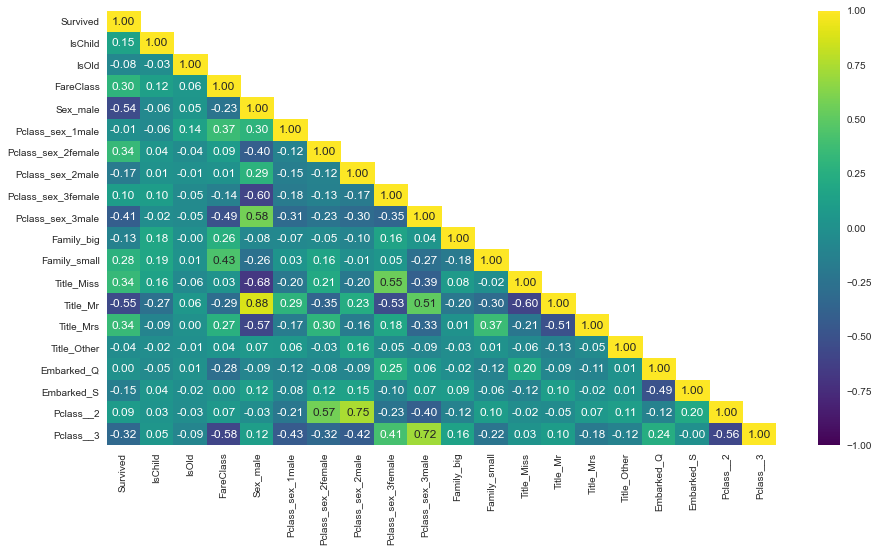

In [68]:
plt.figure(figsize=(15,8))
sns.heatmap(data_combined.corr(), annot=True, fmt='.2f', cmap='viridis', 
            mask=np.triu(np.ones(data_combined.corr().shape), k=1), vmin=-1, vmax=1)

In [69]:
# split data back into train & test
train = data_combined[data_combined['data']=='train'].copy()
test  = data_combined[data_combined['data']=='test'].copy()

train.drop(columns=['data'], inplace=True)
test.drop(columns=['data', 'Survived'], inplace=True)

In [70]:
# train.info(), test.info()

### Anomalies

In [97]:
#setup the experiment
exp_name=setup(data=train, silent=True, verbose=False)

#choose the mode for anomlay detection
pca=create_model('pca')

#apply the model to generate Anomaly_Score and Anomaly
pca_df=assign_model(pca, transformation=True)

#display anomaly index and convert it to list
anomaly_index=pca_df[pca_df["Anomaly"]==1].index.tolist()

In [98]:
len(anomaly_index)

45

In [ ]:
train = train.drop(index=anomaly_index)

## Fiting Models

In [71]:
Y_train = train['Survived']
X_train = train.drop(columns='Survived')
print(Y_train.shape, X_train.shape)

(891,) (891, 19)


In [72]:
X_train.head()

,IsChild,IsOld,FareClass,Sex_male,Pclass_sex_1male,Pclass_sex_2female,Pclass_sex_2male,Pclass_sex_3female,Pclass_sex_3male,Family_big,Family_small,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_Q,Embarked_S,Pclass__2,Pclass__3
0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1
1,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1


In [73]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(test)
# X_train[0:1]
X_test = test

In [74]:
# Decision Tree

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_train)

print('Confusion Matrix: \n',confusion_matrix(Y_train, Y_pred))
print('Classification Report: \n', classification_report(Y_train, Y_pred))

Confusion Matrix: 
 [[506  43]
 [ 78 264]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.92      0.89       549
         1.0       0.86      0.77      0.81       342

    accuracy                           0.86       891
   macro avg       0.86      0.85      0.85       891
weighted avg       0.86      0.86      0.86       891



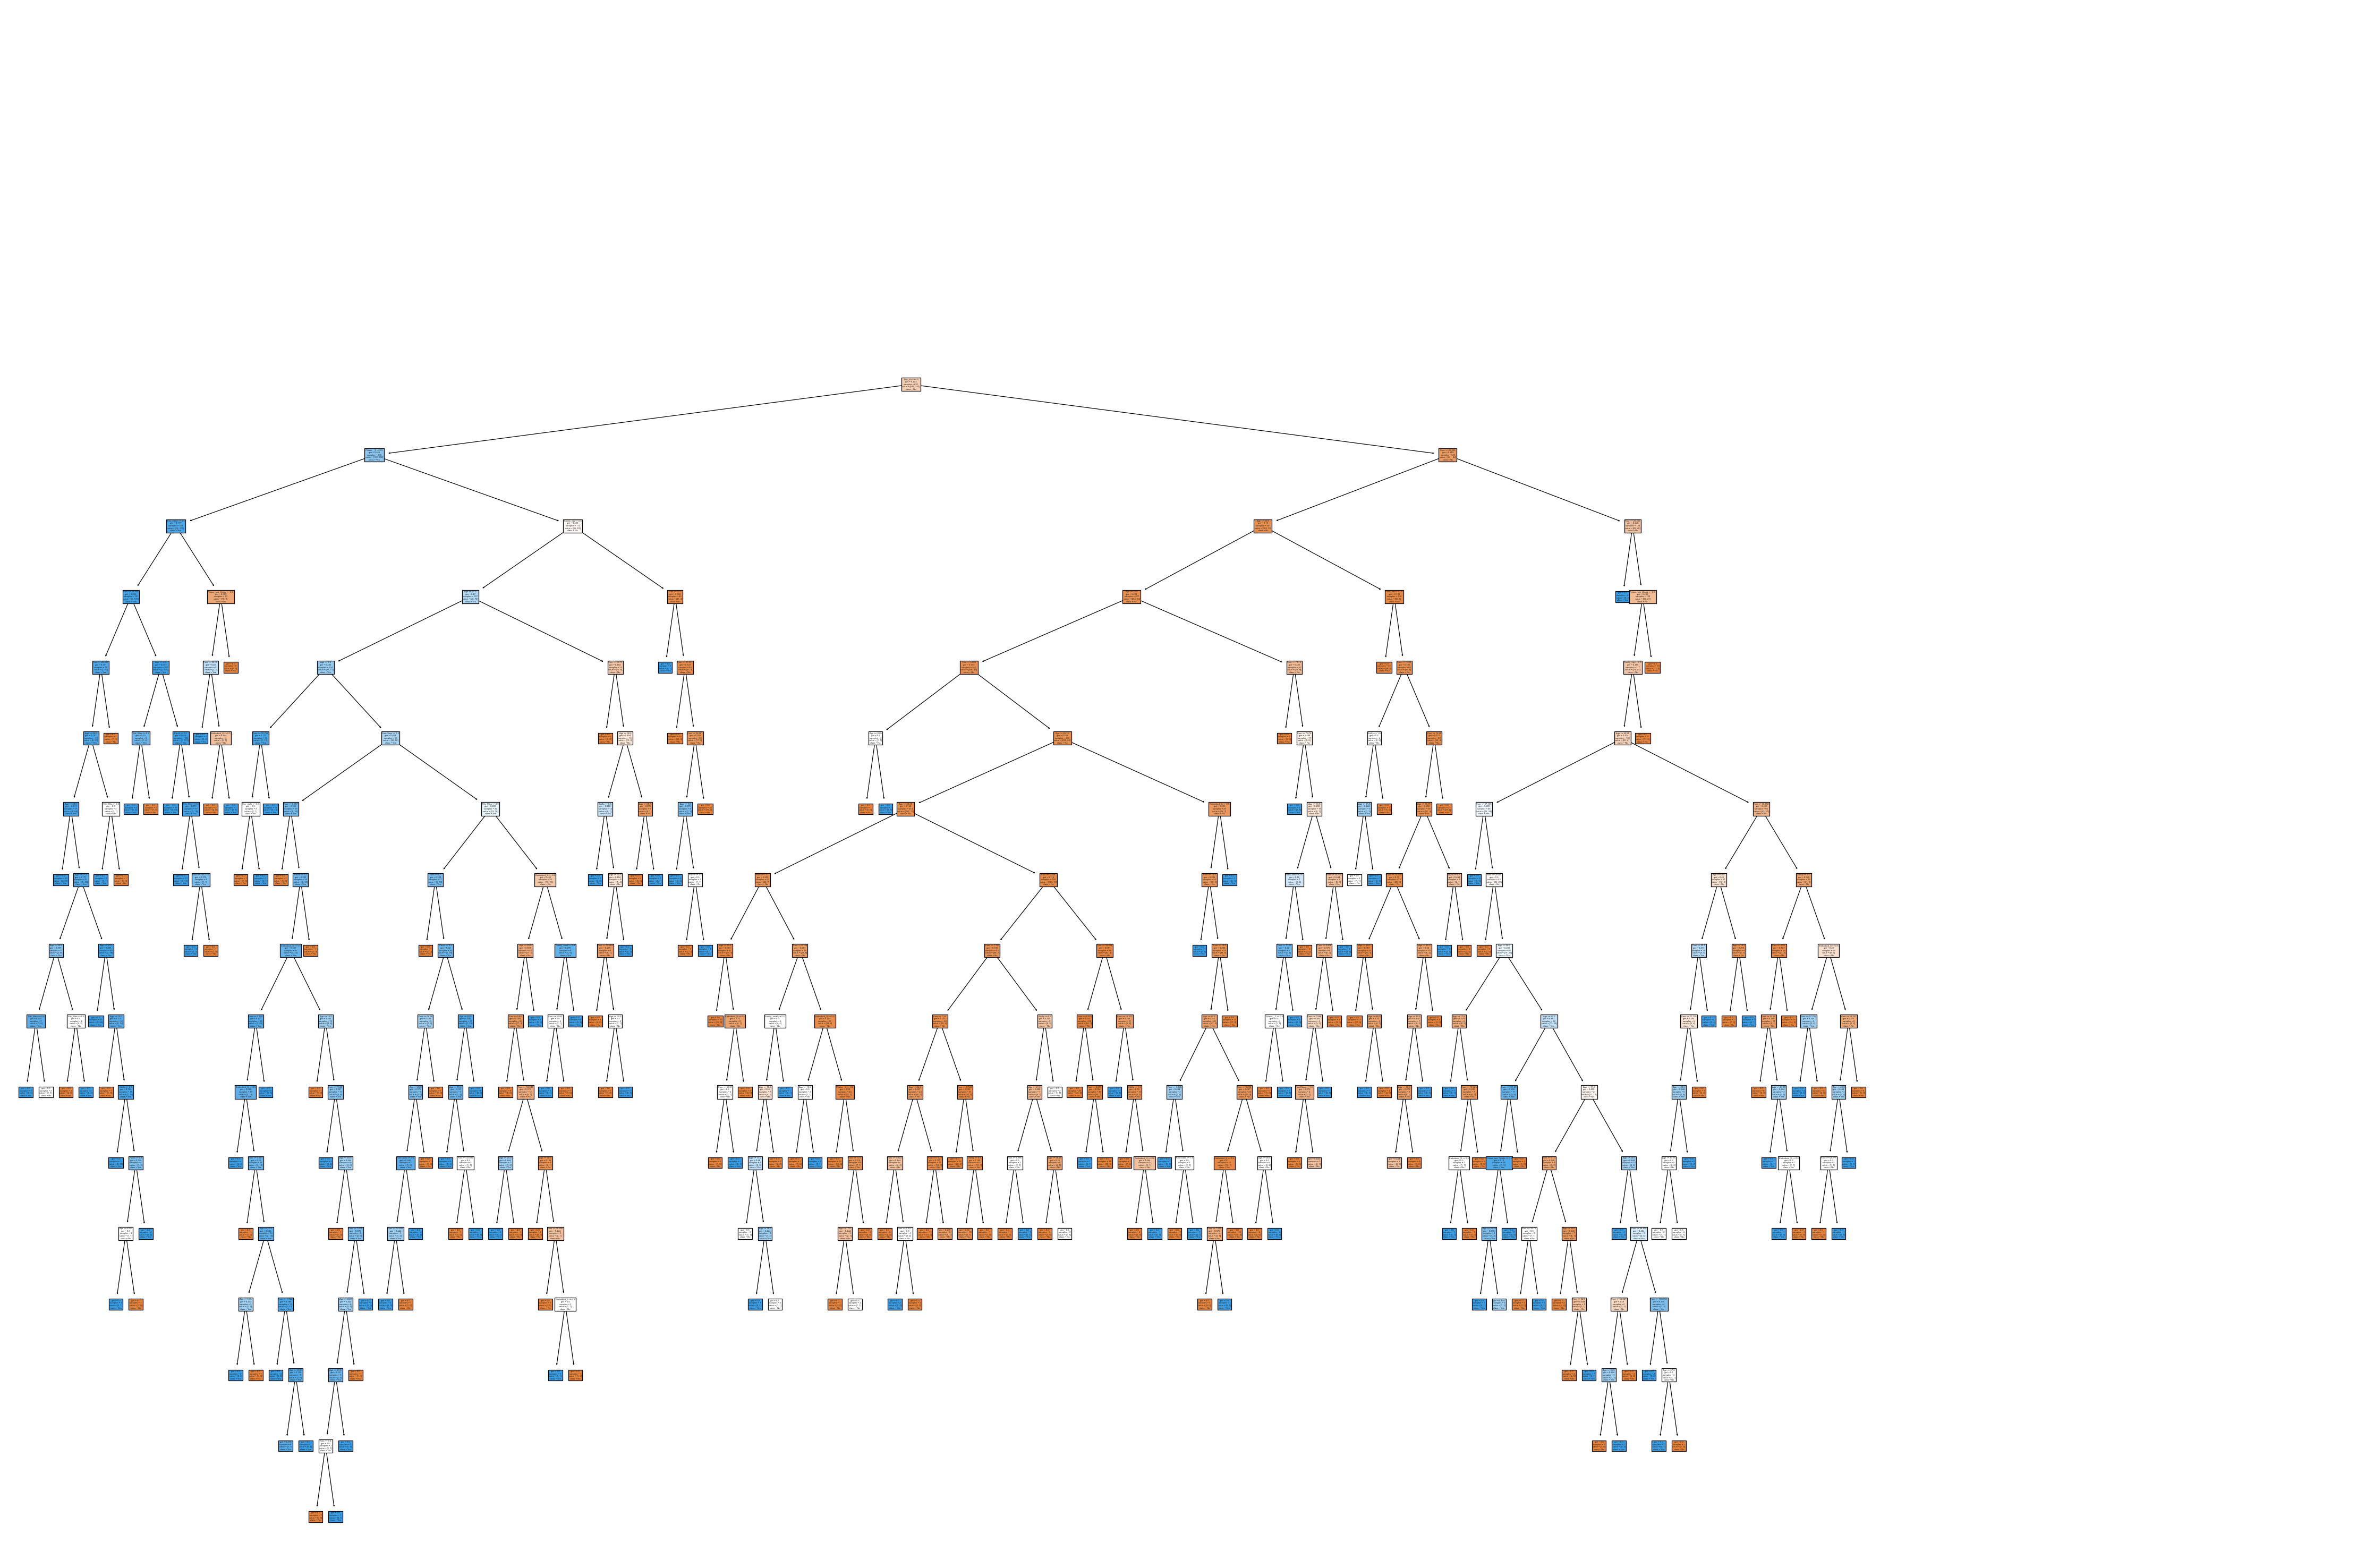

In [48]:
plt.figure(figsize=(15,10), dpi =300)
plot_tree(dt, filled=True, feature_names=train.drop(columns='Survived').columns, class_names=['No', 'Yes']);
plt.tight_layout()
plt.savefig('tree.png', dpi=500)

In [49]:
# Random Forest

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_train)

print('Confusion Matrix: \n',confusion_matrix(Y_train, Y_pred))
print('Classification Report: \n', classification_report(Y_train, Y_pred))

Confusion Matrix: 
 [[542   7]
 [  8 334]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       549
         1.0       0.98      0.98      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



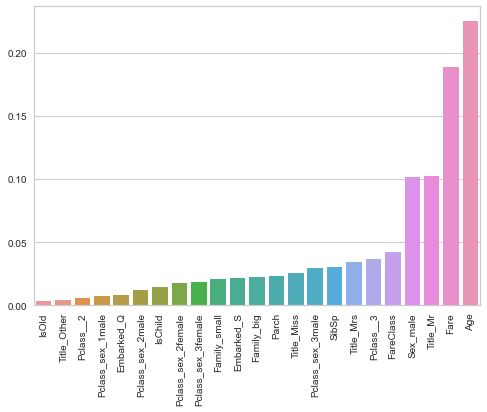

In [52]:
fi = pd.Series(index=X_train.columns, data=rfc.feature_importances_).sort_values()

sns.barplot(x=fi.index, y=fi.values);
plt.xticks(rotation=90);

In [53]:
# XG Boost

xgbt = xgb.XGBClassifier(use_label_encoder=False)
xgbt.fit(X_train, Y_train, eval_metric='logloss')
Y_pred = xgbt.predict(X_train)

print('Confusion Matrix: \n',confusion_matrix(Y_train, Y_pred))
print('Classification Report: \n', classification_report(Y_train, Y_pred))

Confusion Matrix: 
 [[540   9]
 [ 20 322]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       549
         1.0       0.97      0.94      0.96       342

    accuracy                           0.97       891
   macro avg       0.97      0.96      0.97       891
weighted avg       0.97      0.97      0.97       891



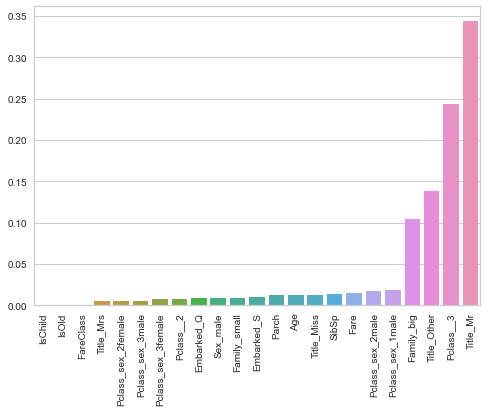

In [54]:
fi = pd.Series(index=X_train.columns, data=xgbt.feature_importances_).sort_values()

sns.barplot(x=fi.index, y=fi.values);
plt.xticks(rotation=90);

In [55]:
param_grid={'max_depth': range (2, 8, 1),
            'n_estimators': range(10, 100, 10),
            'learning_rate': [0.1, 0.01, 0.05, 0.001]}

grid_xgb = GridSearchCV(xgbt, param_grid,cv=5)
grid_xgb.fit(X_train,Y_train, eval_metric='logloss')

print(grid_xgb.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 90}


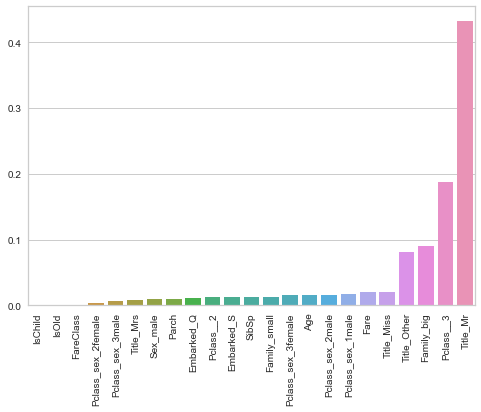

In [60]:
fi = pd.Series(index=X_train.columns, data=grid_xgb.best_estimator_.feature_importances_).sort_values()

sns.barplot(x=fi.index, y=fi.values);
plt.xticks(rotation=90);

In [72]:
# Logistic Regression

logm = LogisticRegression(max_iter=1000)
logm.fit(X_train, Y_train)
Y_pred = logm.predict(X_train)
print(classification_report(Y_train, Y_pred))
print(confusion_matrix(y_true=Y_train,y_pred= Y_pred, labels=[0,1]))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       523
         1.0       0.81      0.74      0.77       328

    accuracy                           0.83       851
   macro avg       0.83      0.82      0.82       851
weighted avg       0.83      0.83      0.83       851

[[466  57]
 [ 85 243]]


In [73]:
# Linear SVC

lsvc = LinearSVC(max_iter=10000)
lsvc.fit(X_train, Y_train)
Y_pred = lsvc.predict(X_train)

print('Confusion Matrix: \n',confusion_matrix(Y_train, Y_pred))
print('Classification Report: \n', classification_report(Y_train, Y_pred))

Confusion Matrix: 
 [[466  57]
 [ 89 239]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       523
         1.0       0.81      0.73      0.77       328

    accuracy                           0.83       851
   macro avg       0.82      0.81      0.82       851
weighted avg       0.83      0.83      0.83       851



In [74]:
# SVC

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_train)

print('Confusion Matrix: \n',confusion_matrix(Y_train, Y_pred))
print('Classification Report: \n', classification_report(Y_train, Y_pred))

Confusion Matrix: 
 [[466  57]
 [ 85 243]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       523
         1.0       0.81      0.74      0.77       328

    accuracy                           0.83       851
   macro avg       0.83      0.82      0.82       851
weighted avg       0.83      0.83      0.83       851



In [75]:
# Naive Bayes

gb = GaussianNB()
gb.fit(X_train, Y_train)
Y_pred = gb.predict(X_train)

print('Confusion Matrix: \n',confusion_matrix(Y_train, Y_pred))
print('Classification Report: \n', classification_report(Y_train, Y_pred))

Confusion Matrix: 
 [[466  57]
 [ 95 233]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       523
         1.0       0.80      0.71      0.75       328

    accuracy                           0.82       851
   macro avg       0.82      0.80      0.81       851
weighted avg       0.82      0.82      0.82       851



In [81]:
# Predictions - logistic
Y_test_pred = logm.predict(X_test).astype(int)
pd.DataFrame(Y_test_pred, columns=['Survived'], index = test_pid).to_csv('TTN_logm.csv')

In [76]:
# Predictions - xgb
Y_test_pred = xgbt.predict(X_test).astype(int)
pd.DataFrame(Y_test_pred, columns=['Survived'], index = test_pid).to_csv('TTN_xgb.csv')

In [61]:
# Predictions - xgb_grid
Y_test_pred = grid_xgb.predict(X_test).astype(int)
pd.DataFrame(Y_test_pred, columns=['Survived'], index = test_pid).to_csv('TTN_xgb_grid.csv')

In [77]:
# Predictions - decision tree
Y_test_pred = dt.predict(X_test).astype(int)
pd.DataFrame(Y_test_pred, columns=['Survived'], index = test_pid).to_csv('TTN_dt.csv')

In [80]:
# Predictions - rf - 0.779 (best so far)
Y_test_pred = rfc.predict(X_test).astype(int)
pd.DataFrame(Y_test_pred, columns=['Survived'], index = test_pid).to_csv('TTN_rfc.csv')